# LLBP: Misprediction Analysis

This notebook parses the result and plots the number of mispredictions for each configuration. It also serves to reproduce the main results (Figure 9) in LLBP paper. As part of EEC 270's class project, novel workloads were also benchmarked for comparison.


In [1]:

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.ticker as mticker

## Simulation Parsing Function

In [2]:
def process_benchmark_results(models, benchmarks, results_dir="./results"):
    """
    Process benchmark results and create a DataFrame with metrics.
    
    Args:
        models: List of tuples (config_name, display_name) for models
        benchmarks: List of tuples (benchmark_name, display_name) for benchmarks
        results_dir: Directory containing results (default: './results')
        
    Returns:
        pandas.DataFrame: Combined results including per-benchmark metrics and means
    """
    dfall = pd.DataFrame()
    
    for cfg, model_name in models:
        # Process each benchmark for this model
        dftmp = pd.DataFrame()
        for bm, bench_name in benchmarks:
            # Read and parse the results file
            try:
                with open(f"{results_dir}/{bm}/{cfg}.txt") as f:
                    metrics = {
                        "Model": model_name,
                        "Benchmark": bench_name,
                        "Ninst": 0,
                        "Misp": 0,
                        "MPKI": 0.0
                    }
                    
                    for line in f:
                        if "ROI INSTRUCTIONS" in line:
                            metrics["Ninst"] = int(line.split()[-1])
                        elif "ROI MISPREDICTIONS" in line:
                            metrics["Misp"] = int(line.split()[-1])
                        elif "ROI MPKI" in line:
                            metrics["MPKI"] = float(line.split()[-1])
                    
                    dftmp = pd.concat([dftmp, pd.DataFrame(metrics, index=[0])])
            except FileNotFoundError:
                print(f"Warning: Could not find results for {bm}/{cfg}")
                continue
        
        print(f"Processed {model_name}: {len(dftmp)} benchmarks")
        
        # Calculate and add means for this model
        if not dftmp.empty:
            means = {
                "Model": model_name,
                "Benchmark": "Mean"
            }
            for metric in dftmp.columns[2:]:  # Skip Model and Benchmark columns
                means[metric] = dftmp[metric].mean()
            
            dfall = pd.concat([dfall, dftmp, pd.DataFrame([means])])

        ## Calculate MPKI reduction
    dfall["MPKI Reduction"] = 0.0
    ref = "64K TSL"

    for bm in dfall["Benchmark"].unique():

        m = "misp"
        m = "MPKI"

        tage64ksc_mpki = dfall.loc[(dfall["Benchmark"] == bm) & (dfall["Model"] == ref), m].values[0]
        dfall.loc[dfall["Benchmark"] == bm, "MPKI Reduction"] = (tage64ksc_mpki - dfall.loc[dfall["Benchmark"] == bm, m]) / tage64ksc_mpki
        
    return dfall


## Absolute MPKI

In [3]:

def plot_absolute_mpki(bms, dfall):
    width = 0.7       # the width of the bars: can also be len(x) sequence


    cw=11.5
    fs=12

    fig, axs = plt.subplots(1, 1, figsize=(cw,cw*0.2), sharex=True, sharey=False)

    _bms = [b[1] for b in bms] + ["Mean"]

    x = np.array([x_+0.3 if l in ["GMean", "Mean"] else x_ for x_,l in enumerate(_bms)])

    colors = {
        '64K TAGE' : '#061b1c',
        '64K TSL' : '#0a2d2e',
        "512K TSL" : '#cfe5e6',
        "LLBP" : '#093316',
        "LLBP-0Lat" : '#3e6f70',
    }


    plot_models = [

        "64K TAGE",
        "64K TSL",
        "LLBP",
        "LLBP-0Lat",
        "512K TSL",
    ]


    nbars = len(plot_models)
    bar_width = float(1) / float(nbars+0.5)
    init_offset = float(-nbars*bar_width) / 2
    get_offset = lambda n : init_offset + n * bar_width


    ax = axs

    m = "MPKI"

    for i, model in enumerate(plot_models):

        # if i == 0:
        #     continue


        dftmp = dfall[dfall["Model"] == model].set_index("Benchmark")

        y = dftmp.loc[_bms, m].values
        print(f"\n{model} MPKIs:")
        print()
        for benchmark, value in zip(_bms, y):
            print(f"{benchmark}: {value:.2f}")


        ax.bar(x+get_offset(i), y, width=bar_width, bottom=0, #hatch=hatches[j],
                color=colors[model], label=model,
                align='edge', edgecolor='k',zorder=2.3)





    ## Grid
    ax.yaxis.set_minor_locator(mticker.AutoMinorLocator(2))
    ax.grid(True, which='both')
    ax.grid(True, which='minor', linestyle=':')

    ax.set_ylabel("Branch MPKI", fontsize=fs)

    _y = ax.get_yticks()
    ax.set_yticks(_y)
    ax.set_yticklabels([f"{y:.3f}" for y in _y], fontsize=fs-1)

    # for container in ax.containers:
    #     ax.bar_label(container, fontsize=7, fmt="%.2f", rotation=90)


    ## Format x-axis
    ax.set_xticks(x)
    ax.set_xticklabels(_bms, rotation=10, horizontalalignment="center", fontsize=fs-1)
    ax.tick_params(axis='x', which='major', pad=0)

    ax.set_ylim(auto=True)



    handles, labels = ax.get_legend_handles_labels()

    ax.legend(handles, labels, bbox_to_anchor=(0.5,1.03), loc="upper center", fontsize=fs, ncol=8,
                labelspacing=0.05, columnspacing=1.,handletextpad=0.2,borderpad=0.2,frameon=True)

    # ax.legend(loc="best", fontsize="9", )
    ax.set_xlim(auto=True)





    fig.tight_layout()


    fig.savefig("mpki.pdf",dpi=300,format="pdf",bbox_inches='tight', pad_inches=0, facecolor="w")
    # fig.savefig("performance_study.png",dpi=300,bbox_inches='tight', pad_inches=0, facecolor="w")

## MPKI Reduction Plotting

In [4]:

def plot_mpki_reduction(bms, dfall):
    width = 0.7
    cw=11.5
    fs=12

    fig, axs = plt.subplots(1, 1, figsize=(cw,cw*0.2), sharex=True, sharey=False)

    _bms = [b[1] for b in bms] + ["Mean"]

    x = np.array([x_+0.3 if l in ["GMean", "Mean"] else x_ for x_,l in enumerate(_bms)])

    colors = {
        '64K TSL' : '#061b1c',
        "LLBP" : '#093316',
        "LLBP-0Lat" : '#3e6f70',
        "512K TSL" : '#cfe5e6'
    }

    plot_models = [
        "64K TSL",
        "LLBP",
        "LLBP-0Lat", 
        "512K TSL"
    ]

    nbars = len(plot_models)
    bar_width = float(1) / float(nbars+0.5)
    init_offset = float(-nbars*bar_width) / 2
    get_offset = lambda n : init_offset + n * bar_width

    ax = axs

    # Get baseline (TAGE) MPKI values
    tage_df = dfall[dfall["Model"] == "64K TAGE"].set_index("Benchmark")
    tage_mpki = tage_df.loc[_bms, "MPKI"].values

    # Plot reduction compared to TAGE
    for i, model in enumerate(plot_models):
        print(model)
        dftmp = dfall[dfall["Model"] == model].set_index("Benchmark")
        model_mpki = dftmp.loc[_bms, "MPKI"].values
        
        # Calculate reduction compared to TAGE
        reduction = (tage_mpki - model_mpki) / tage_mpki

        ax.bar(x+get_offset(i), reduction, width=bar_width, bottom=0,
                color=colors[model], label=model,
                align='edge', edgecolor='k',zorder=2.3)





    ## Grid
    ax.yaxis.set_minor_locator(mticker.AutoMinorLocator(2))
    ax.grid(True, which='both')
    ax.grid(True, which='minor', linestyle=':')

    ax.set_ylabel("Branch MPKI\nReduction [%]", fontsize=fs)

    _y = ax.get_yticks()
    ax.set_yticks(_y)
    ax.set_yticklabels([f"{y*100:.0f}" for y in _y], fontsize=fs-1)

    # for container in ax.containers:
    #     ax.bar_label(container, fontsize=7, fmt="%.3f", rotation=90)


    ## Format x-axis
    ax.set_xticks(x)
    ax.set_xticklabels(_bms, rotation=10, horizontalalignment="center", fontsize=fs-1)
    ax.tick_params(axis='x', which='major', pad=0)

    ax.set_ylim(auto=True)



    handles, labels = ax.get_legend_handles_labels()

    ax.legend(handles, labels, bbox_to_anchor=(0.98,1.03), loc="upper right", fontsize=fs, ncol=8,
                labelspacing=0.05, columnspacing=1.,handletextpad=0.2,borderpad=0.2,frameon=True)

    ax.set_xlim(left=x[0]-0.8, right=x[-1]+0.8)





    fig.tight_layout()


    fig.savefig("mpki_reduction.pdf",dpi=300,format="pdf",bbox_inches='tight', pad_inches=0, facecolor="w")

## Paper Recreation

In [5]:

dict = {}



models = [

    ("tage64k-ae", "64K TAGE"),
    ("tage64kscl-ae", "64K TSL"),
    ("tage512kscl-ae", "512K TSL"),
    ("llbp-timing-ae", "LLBP"),
    ("llbp-ae", "LLBP-0Lat"),

]

bms = [
    ('nodeapp-nodeapp', 'NodeApp'),
    ('mwnginxfpm-wiki', 'PHPWiki'),

    ('benchbase-tpcc', 'TPCC'),
    ('benchbase-twitter', 'Twitter'),
    ('benchbase-wikipedia', 'Wikipedia'),
    ('dacapo-kafka', 'Kafka'),
    ('dacapo-spring', 'Spring'),
    ('dacapo-tomcat', 'Tomcat'),
    ('renaissance-finagle-chirper', 'Chirper'),
    ('renaissance-finagle-http', 'HTTP'),

    ('charlie.1006518', 'Charlie'),
    ('delta.507252', 'Delta'),
    ('merced.467915', 'Merced'),
    ('whiskey.426708', 'Whiskey')
]

df_recreate = process_benchmark_results(models,bms)


Processed 64K TAGE: 14 benchmarks
Processed 64K TSL: 14 benchmarks
Processed 512K TSL: 14 benchmarks
Processed LLBP: 14 benchmarks
Processed LLBP-0Lat: 14 benchmarks


## Absolute MPKI of LLBP Paper Benchmarks


64K TAGE MPKIs:

NodeApp: 3.65
PHPWiki: 2.75
TPCC: 2.98
Twitter: 3.49
Wikipedia: 2.21
Kafka: 0.20
Spring: 3.56
Tomcat: 3.68
Chirper: 0.40
HTTP: 1.62
Charlie: 3.28
Delta: 1.03
Merced: 4.22
Whiskey: 5.17
Mean: 2.73

64K TSL MPKIs:

NodeApp: 3.53
PHPWiki: 2.68
TPCC: 2.75
Twitter: 3.30
Wikipedia: 2.10
Kafka: 0.18
Spring: 3.38
Tomcat: 3.48
Chirper: 0.36
HTTP: 1.54
Charlie: 3.14
Delta: 0.98
Merced: 4.02
Whiskey: 4.82
Mean: 2.59

LLBP MPKIs:

NodeApp: 2.50
PHPWiki: 2.31
TPCC: 2.54
Twitter: 3.17
Wikipedia: 1.93
Kafka: 0.17
Spring: 3.04
Tomcat: 3.24
Chirper: 0.34
HTTP: 1.51
Charlie: 2.90
Delta: 0.96
Merced: 3.59
Whiskey: 4.56
Mean: 2.34

LLBP-0Lat MPKIs:

NodeApp: 2.37
PHPWiki: 2.08
TPCC: 2.50
Twitter: 3.13
Wikipedia: 1.90
Kafka: 0.17
Spring: 3.01
Tomcat: 3.21
Chirper: 0.33
HTTP: 1.49
Charlie: 2.87
Delta: 0.95
Merced: 3.51
Whiskey: 4.52
Mean: 2.29

512K TSL MPKIs:

NodeApp: 1.75
PHPWiki: 1.62
TPCC: 1.99
Twitter: 2.61
Wikipedia: 1.54
Kafka: 0.13
Spring: 1.73
Tomcat: 2.65
Chirper: 0.26
HTTP: 1.3

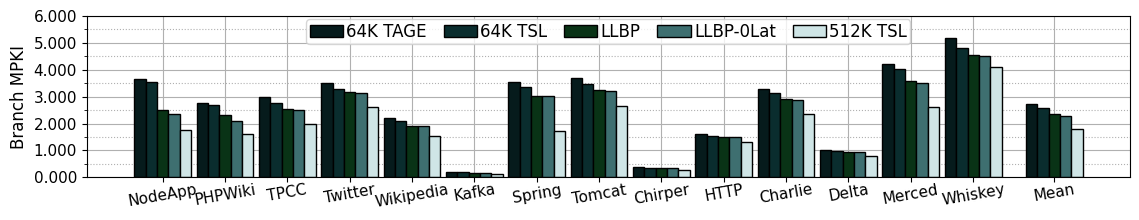

In [6]:
plot_absolute_mpki(bms, df_recreate)

## MPKI Reduction (LLBP Paper Fig. 9)

64K TSL
LLBP
LLBP-0Lat
512K TSL


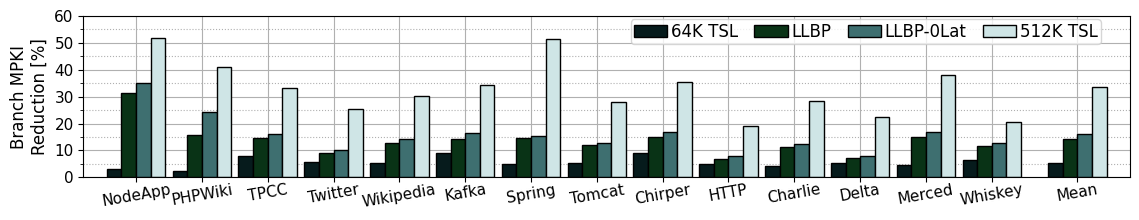

In [7]:
plot_mpki_reduction(bms, df_recreate)

# EEC 270 Benchmarks

## mmperf: Matrix Multiplication Benchmarks
https://github.com/mmperf/mmperf  

This is a benchmark suite offering high-performance matrix multiplication CPU kernels with non-trivial matrix sizes. These simulation runs were done with the OpenBLAS backend.

Processed 64K TAGE: 7 benchmarks
Processed 64K TSL: 7 benchmarks
Processed 512K TSL: 7 benchmarks
Processed LLBP: 7 benchmarks
Processed LLBP-0Lat: 7 benchmarks

64K TAGE MPKIs:

100x384x4032: 0.09
384x384x512: 0.12
1024x1024x1024: 0.10
3072x1024x512: 0.14
12544x64x147: 0.07
22201x64x288: 0.06
22500x32x27: 0.11
Mean: 0.10

64K TSL MPKIs:

100x384x4032: 0.05
384x384x512: 0.09
1024x1024x1024: 0.05
3072x1024x512: 0.09
12544x64x147: 0.05
22201x64x288: 0.04
22500x32x27: 0.10
Mean: 0.07

LLBP MPKIs:

100x384x4032: 0.06
384x384x512: 0.09
1024x1024x1024: 0.05
3072x1024x512: 0.09
12544x64x147: 0.05
22201x64x288: 0.05
22500x32x27: 0.10
Mean: 0.07

LLBP-0Lat MPKIs:

100x384x4032: 0.06
384x384x512: 0.10
1024x1024x1024: 0.05
3072x1024x512: 0.10
12544x64x147: 0.05
22201x64x288: 0.05
22500x32x27: 0.10
Mean: 0.07

512K TSL MPKIs:

100x384x4032: 0.02
384x384x512: 0.01
1024x1024x1024: 0.03
3072x1024x512: 0.08
12544x64x147: 0.01
22201x64x288: 0.04
22500x32x27: 0.01
Mean: 0.03
64K TSL
LLBP
LLBP-0Lat
512K 

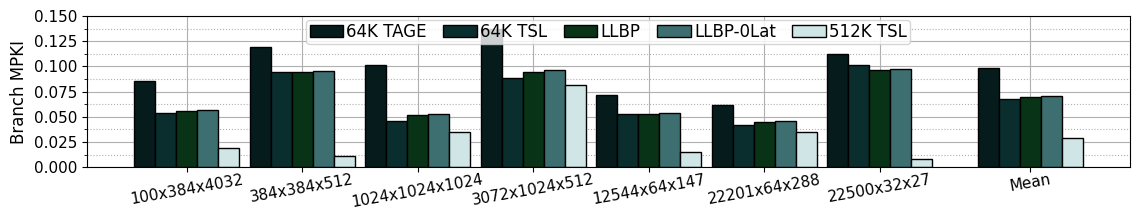

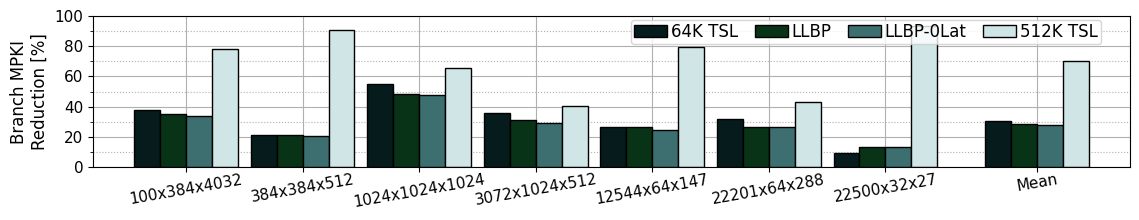

In [8]:
bms_mmperf = [
    ('matmul_100x384x4032', '100x384x4032'),
    ('matmul_384x384x512', '384x384x512'),
    ('matmul_1024x1024x1024', '1024x1024x1024'),
    ('matmul_3072x1024x512', '3072x1024x512'),
    ('matmul_12544x64x147', '12544x64x147'),
    ('matmul_22201x64x288', '22201x64x288'),
    ('matmul_22500x32x27', '22500x32x27')
]

df_mmperf = process_benchmark_results(models, bms_mmperf)
plot_absolute_mpki(bms_mmperf, df_mmperf)
plot_mpki_reduction(bms_mmperf, df_mmperf)

## SpMV: Sparse Matrix Vector Multiplication Benchmarks
https://github.com/Sable/fait-maison-spmv  

fait-mason-spmv provides "conventional implementations of SpMV that target cache-based superscalar uniprocessor machines." These simulation runs were done using the sequential C implementation with double precision. The matrices used are the same as the graphs provided with the GAP benchmark suite: usroads, Twitter, and sk-2005. 

Processed 64K TAGE: 3 benchmarks
Processed 64K TSL: 3 benchmarks
Processed 512K TSL: 3 benchmarks
Processed LLBP: 3 benchmarks
Processed LLBP-0Lat: 3 benchmarks

64K TAGE MPKIs:

us-roads: 0.24
Twitter: 0.17
sk-2005: 0.00
Mean: 0.14

64K TSL MPKIs:

us-roads: 0.24
Twitter: 0.16
sk-2005: 0.00
Mean: 0.13

LLBP MPKIs:

us-roads: 0.24
Twitter: 0.17
sk-2005: 0.00
Mean: 0.14

LLBP-0Lat MPKIs:

us-roads: 0.24
Twitter: 0.17
sk-2005: 0.00
Mean: 0.14

512K TSL MPKIs:

us-roads: 0.24
Twitter: 0.16
sk-2005: 0.00
Mean: 0.13
64K TSL
LLBP
LLBP-0Lat
512K TSL


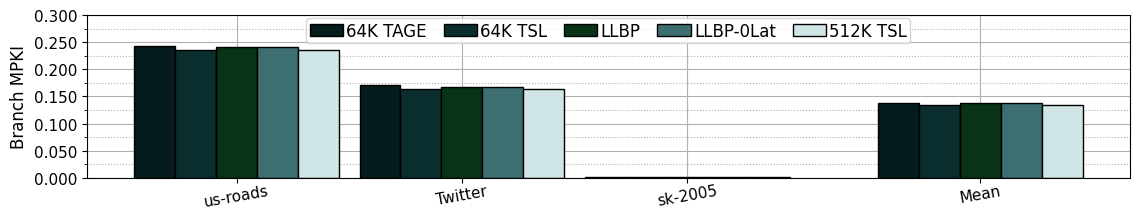

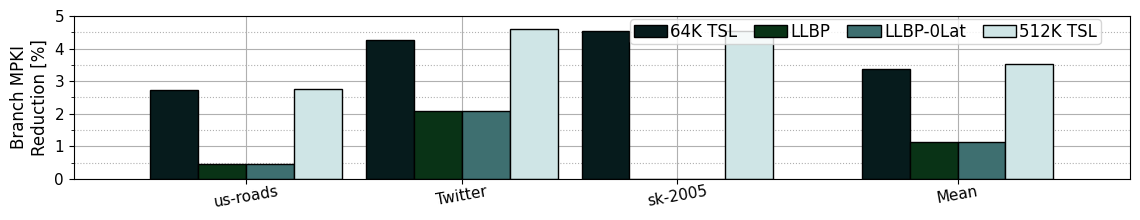

In [9]:
bms_spmv = [
    ('spmv_GAP-road', 'us-roads'),
    ('spmv_GAP-twitter', 'Twitter'),
    ('spmv_sk-2005', 'sk-2005')
]

df_spmv = process_benchmark_results(models, bms_spmv)
plot_absolute_mpki(bms_spmv, df_spmv)
plot_mpki_reduction(bms_spmv, df_spmv)

## gapbs: Graph Algorithm Benchmarks

These simulation runs were done using the standard GAP graphs.

Processed 64K TAGE: 3 benchmarks
Processed 64K TSL: 3 benchmarks
Processed 512K TSL: 3 benchmarks
Processed LLBP: 3 benchmarks
Processed LLBP-0Lat: 3 benchmarks

64K TAGE MPKIs:

bc-road: 0.28
bc-twitter: 0.18
bc-web: 0.10
Mean: 0.18

64K TSL MPKIs:

bc-road: 0.25
bc-twitter: 0.14
bc-web: 0.07
Mean: 0.15

LLBP MPKIs:

bc-road: 0.25
bc-twitter: 0.15
bc-web: 0.07
Mean: 0.16

LLBP-0Lat MPKIs:

bc-road: 0.25
bc-twitter: 0.15
bc-web: 0.08
Mean: 0.16

512K TSL MPKIs:

bc-road: 0.25
bc-twitter: 0.14
bc-web: 0.07
Mean: 0.15
64K TSL
LLBP
LLBP-0Lat
512K TSL


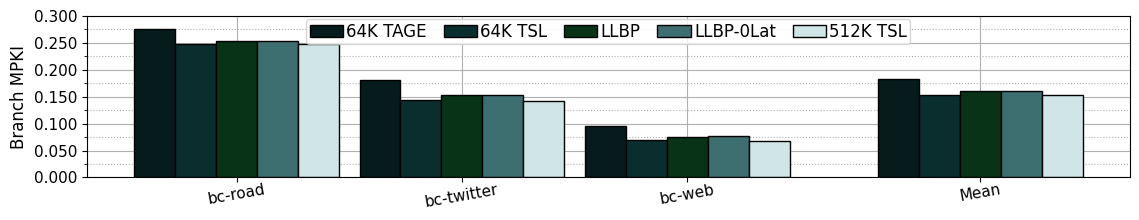

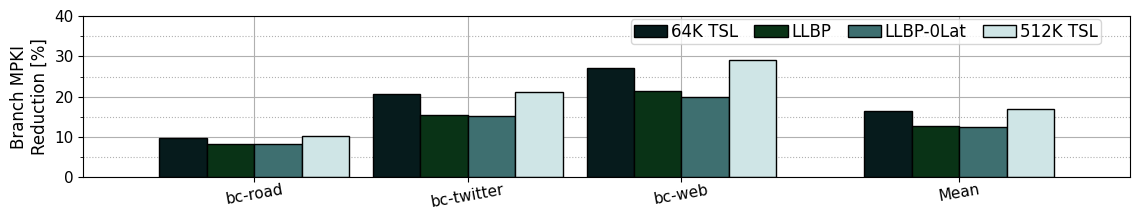

In [10]:
bms_gapbs_bc = [
    ('bc_road', 'bc-road'),
    ('bc_twitter', 'bc-twitter'),
    ('bc_web', 'bc-web'),

]

df_gapbs_bc = process_benchmark_results(models, bms_gapbs_bc)
plot_absolute_mpki(bms_gapbs_bc, df_gapbs_bc)
plot_mpki_reduction(bms_gapbs_bc, df_gapbs_bc)

Processed 64K TAGE: 3 benchmarks
Processed 64K TSL: 3 benchmarks
Processed 512K TSL: 3 benchmarks
Processed LLBP: 3 benchmarks
Processed LLBP-0Lat: 3 benchmarks

64K TAGE MPKIs:

bfs-road: 0.75
bfs-twitter: 0.52
bfs-web: 0.00
Mean: 0.42

64K TSL MPKIs:

bfs-road: 0.21
bfs-twitter: 0.27
bfs-web: 0.00
Mean: 0.16

LLBP MPKIs:

bfs-road: 0.26
bfs-twitter: 0.30
bfs-web: 0.00
Mean: 0.19

LLBP-0Lat MPKIs:

bfs-road: 0.26
bfs-twitter: 0.30
bfs-web: 0.00
Mean: 0.19

512K TSL MPKIs:

bfs-road: 0.17
bfs-twitter: 0.24
bfs-web: 0.00
Mean: 0.13
64K TSL
LLBP
LLBP-0Lat
512K TSL


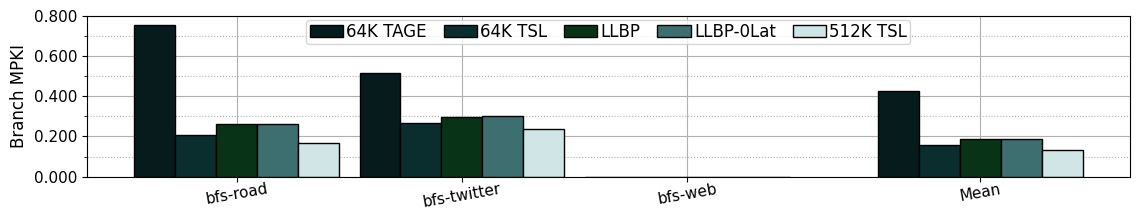

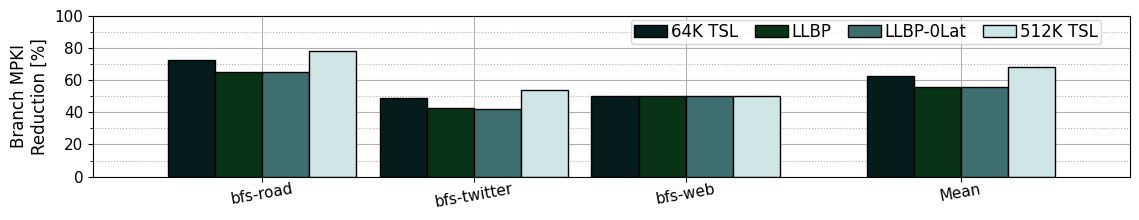

In [11]:
bms_gapbs_bfs = [
    ('bfs_road', 'bfs-road'),
    ('bfs_twitter', 'bfs-twitter'),
    ('bfs_web', 'bfs-web'),

]

df_gapbs_bfs = process_benchmark_results(models, bms_gapbs_bfs)
plot_absolute_mpki(bms_gapbs_bfs, df_gapbs_bfs)
plot_mpki_reduction(bms_gapbs_bfs, df_gapbs_bfs)

Processed 64K TAGE: 3 benchmarks
Processed 64K TSL: 3 benchmarks
Processed 512K TSL: 3 benchmarks
Processed LLBP: 3 benchmarks
Processed LLBP-0Lat: 3 benchmarks

64K TAGE MPKIs:

cc-road: 0.75
cc-twitter: 0.18
cc-web: 0.29
Mean: 0.41

64K TSL MPKIs:

cc-road: 0.20
cc-twitter: 0.14
cc-web: 0.22
Mean: 0.19

LLBP MPKIs:

cc-road: 0.20
cc-twitter: 0.14
cc-web: 0.23
Mean: 0.19

LLBP-0Lat MPKIs:

cc-road: 0.25
cc-twitter: 0.14
cc-web: 0.23
Mean: 0.21

512K TSL MPKIs:

cc-road: 0.20
cc-twitter: 0.14
cc-web: 0.21
Mean: 0.18
64K TSL
LLBP
LLBP-0Lat
512K TSL


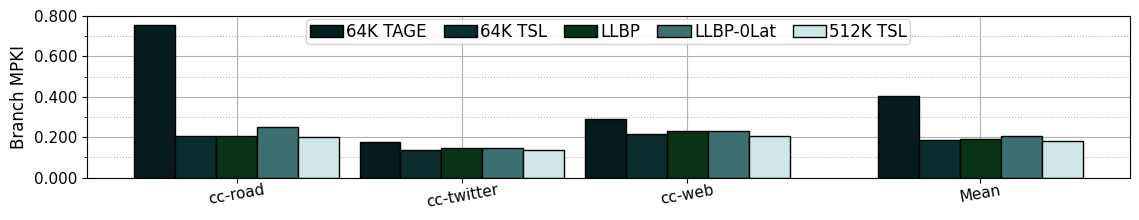

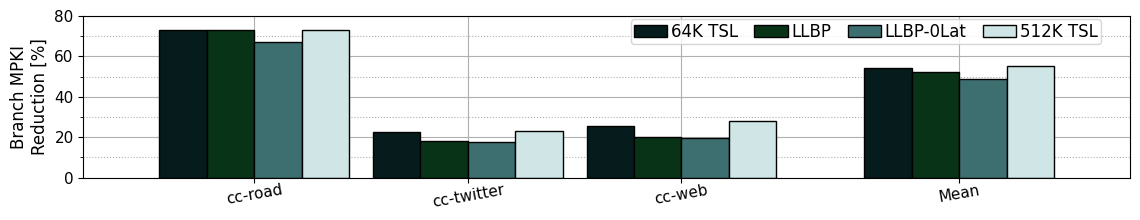

In [12]:
bms_gapbs_cc = [
    ('cc_road', 'cc-road'),
    ('cc_twitter', 'cc-twitter'),
    ('cc_web', 'cc-web'),

]

df_gapbs_cc = process_benchmark_results(models, bms_gapbs_cc)
plot_absolute_mpki(bms_gapbs_cc, df_gapbs_cc)
plot_mpki_reduction(bms_gapbs_cc, df_gapbs_cc)

Processed 64K TAGE: 3 benchmarks
Processed 64K TSL: 3 benchmarks
Processed 512K TSL: 3 benchmarks
Processed LLBP: 3 benchmarks
Processed LLBP-0Lat: 3 benchmarks

64K TAGE MPKIs:

pr-road: 0.30
pr-twitter: 0.02
pr-web: 0.00
Mean: 0.11

64K TSL MPKIs:

pr-road: 0.27
pr-twitter: 0.01
pr-web: 0.00
Mean: 0.09

LLBP MPKIs:

pr-road: 0.28
pr-twitter: 0.01
pr-web: 0.00
Mean: 0.10

LLBP-0Lat MPKIs:

pr-road: 0.28
pr-twitter: 0.01
pr-web: 0.00
Mean: 0.10

512K TSL MPKIs:

pr-road: 0.27
pr-twitter: 0.01
pr-web: 0.00
Mean: 0.09
64K TSL
LLBP
LLBP-0Lat
512K TSL


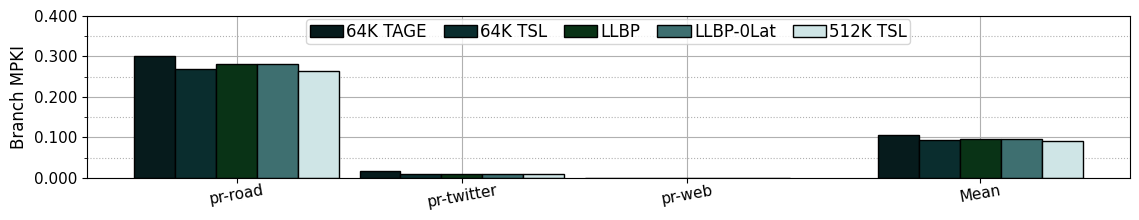

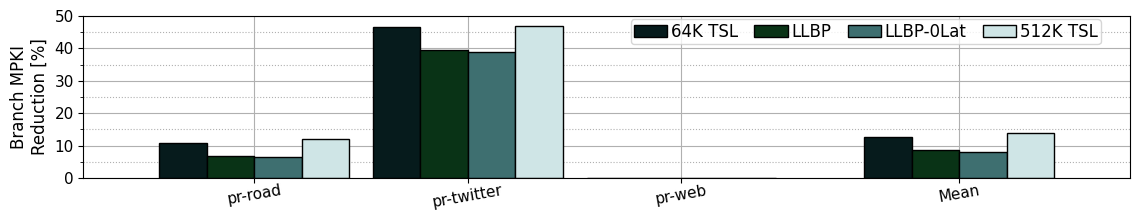

In [13]:
bms_gapbs_pr = [
    ('pr_road', 'pr-road'),
    ('pr_twitter', 'pr-twitter'),
    ('pr_web', 'pr-web'),

]

df_gapbs_pr = process_benchmark_results(models, bms_gapbs_pr)
plot_absolute_mpki(bms_gapbs_pr, df_gapbs_pr)
plot_mpki_reduction(bms_gapbs_pr, df_gapbs_pr)